# **Exploratory Data Analysis (EDA) of Crunchbase company and investor information**

The Pledge 1% community of 7.4K organizations has a unique footprint within the Crunchbase dataset of 1.1M organizations. Important to note: in this early stage of review, we removed records that were missing field values.

In [1]:
# User defined functions
import base_methods
from importlib import reload
from base_methods import load_the_csvs, reformat_large_tick_values, column_formatter

# Import data analysis packages
import numpy as np
import pandas as pd
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')

# Import plotting packages
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import PercentFormatter
sns.set(font_scale=1.3)
sns.set_style("white")

### Loading data

Data sourced from the <a href='https://www.crunchbase.com/'>Crunchbase API</a> via Pledge 1%'s Enterprise License Agreement.

In [2]:
# Store path to notebook
PWD = !pwd
PWD = PWD[0]

# Set global paths to data folders
!mkdir {PWD}/files/output/
print()
INPUT = PWD + '/files/csv/'
OUTPUT = PWD + '/files/output/'

# Load
pledge1,org,inv,fun,part = load_the_csvs(loc=INPUT,
                                         data=['p1','organizations','investments',
                                               'funding_rounds','investment_partners'],
                                         verbose=True)

mkdir: cannot create directory ‘/home/ski/Desktop/crunchbase-p1-machine-learning/files/output/’: File exists

/HOME/SKI/DESKTOP/CRUNCHBASE-P1-MACHINE-LEARNING/FILES/CSV/P1.CSV
P1 shape: (7822, 3)
P1 columns: ['uuid', 'p1_tag', 'p1_date']

/HOME/SKI/DESKTOP/CRUNCHBASE-P1-MACHINE-LEARNING/FILES/CSV/ORGANIZATIONS.CSV
ORGANIZATIONS shape: (1131310, 41)
ORGANIZATIONS columns: ['uuid', 'name', 'type', 'permalink', 'cb_url', 'rank', 'created_at', 'updated_at', 'legal_name', 'roles', 'domain', 'homepage_url', 'country_code', 'state_code', 'region', 'city', 'address', 'postal_code', 'status', 'short_description', 'category_list', 'category_groups_list', 'num_funding_rounds', 'total_funding_usd', 'total_funding', 'total_funding_currency_code', 'founded_on', 'last_funding_on', 'closed_on', 'employee_count', 'email', 'phone', 'facebook_url', 'linkedin_url', 'twitter_url', 'logo_url', 'alias1', 'alias2', 'alias3', 'primary_role', 'num_exits']

/HOME/SKI/DESKTOP/CRUNCHBASE-P1-MACHINE-LEARNING/FILES/

## Examining Pledge 1% data

### What are the top VC firms in the Pledge 1% community?

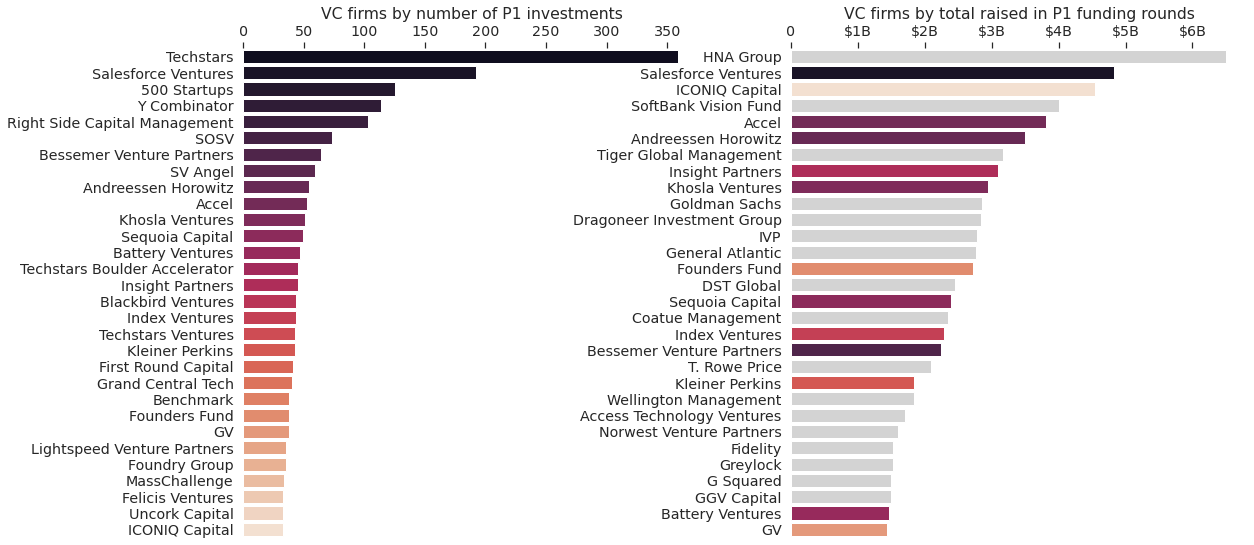

In [3]:
# Merge org and p1 datasets on org uuid
df = pd.merge(org, pledge1, on='uuid', how='inner')
df['p1_tag'] = df['p1_tag'].apply(lambda x:1 if x==True else 0)

# Update columns
df = df[['uuid', 'p1_tag']]

# Only select p1 companies 
df = df[df['p1_tag'] == 1]

# Join organization and funding round data to get funding rounds for p1 organizations
df['org_uuid'] = df['uuid']
df.drop('uuid', axis=1, inplace=True)
df = pd.merge(df, fun, on='org_uuid', how='inner')

# Update columns
df = df[['uuid', 'org_name','raised_amount_usd']].rename({'uuid':'funding_round_uuid'},axis=1)

# Merge df with investments data on funding_round_uuid
cb = pd.merge(df, inv, on='funding_round_uuid', how='inner')

# If a lead investor, set equal to 1 else 0
cb['lead_count'] = 0
cb.loc[cb['is_lead_investor']==True, 'lead_count'] = 1 
cb = cb[['org_name', 'raised_amount_usd', 'investor_name', 'investor_type', 'lead_count']]

# Merge df with investments data on funding_round_uuid
cb_p = pd.merge(df, part, on='funding_round_uuid', how='inner')
cb_p = cb_p[['org_name', 'raised_amount_usd', 'partner_name']]

# Set number of VCs to display for plotting
num_to_compare = 30

# Create a new aggregated dataset grouped on investor_name by aggregating raised_amount_usd
p1_co_invest_cash = cb.groupby('investor_name', as_index=False)\
                      .agg({'raised_amount_usd':'sum', 'org_name':'count'})\
                      .sort_values('raised_amount_usd', ascending=False)[:num_to_compare].reset_index(drop=True)

# Create a new aggregated dataset grouped on investor_name by aggregating raised_amount_usd
p1_co_invest_count = cb.groupby('investor_name', as_index=False)\
                       .agg({'raised_amount_usd':'sum', 'org_name':'count'})\
                       .sort_values('org_name', ascending=False)[:num_to_compare].reset_index(drop=True)

# Create a new aggregated dataset grouped on investor_name by aggregating raised_amount_usd
p1_p_invest_cash = cb_p.groupby('partner_name', as_index=False)\
                       .agg({'raised_amount_usd':'sum', 'org_name':'count'})\
                       .sort_values('raised_amount_usd', ascending=False)[:num_to_compare].reset_index(drop=True)

# Create a new aggregated dataset grouped on investor_name by aggregating raised_amount_usd
p1_p_invest_count = cb_p.groupby('partner_name', as_index=False)\
                        .agg({'raised_amount_usd':'sum', 'org_name':'count'})\
                        .sort_values('org_name', ascending=False)[:num_to_compare].reset_index(drop=True)

# Plot the investor subplots
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,9))

# By count
bar1 = sns.barplot(x='org_name', y='investor_name', palette='rocket', data=p1_co_invest_count, orient='h', ax=ax[0])
ax[0].xaxis.set_ticks_position('top')
ax[0].set_title('VC firms by number of P1 investments')
ax[0].set_xlabel('')
ax[0].set_ylabel('')

# By cash
bar2 = sns.barplot(x='raised_amount_usd', y='investor_name', color='lightgrey',data=p1_co_invest_cash, orient='h', ax=ax[1])
ax[1].xaxis.set_ticks_position('top')
ax[1].xaxis.set_major_formatter(ticker.FuncFormatter(reformat_large_tick_values))
ax[1].set_title('VC firms by total raised in P1 funding rounds')
ax[1].set_xlabel('')
ax[1].set_ylabel('')

# Make overlapping companies share facecolor
patch_h = []
for patch in bar1.patches:
    reading = patch.get_facecolor()
    patch_h.append(reading)
match_colors = dict(zip(p1_co_invest_count['investor_name'].to_list(), patch_h))
for idx, company in enumerate(p1_co_invest_cash['investor_name'].to_list()):
    if company in match_colors.keys():
        bar2.patches[idx].set_facecolor(match_colors[company]) 

# Display
sns.despine(left=True, bottom=True)        
plt.show()

Techstars, 500 Startups, Y Combinator, SOVC, and SV Angel are early stage investors which explains their high investment count but lack of presence on the right plot of total funding round sizes ($). Not surprisingly, VC firms that are on both sides of these plots are well-known by Pledge 1\% staff and our partners.

### Who are the top partner investors in the Pledge 1% community?

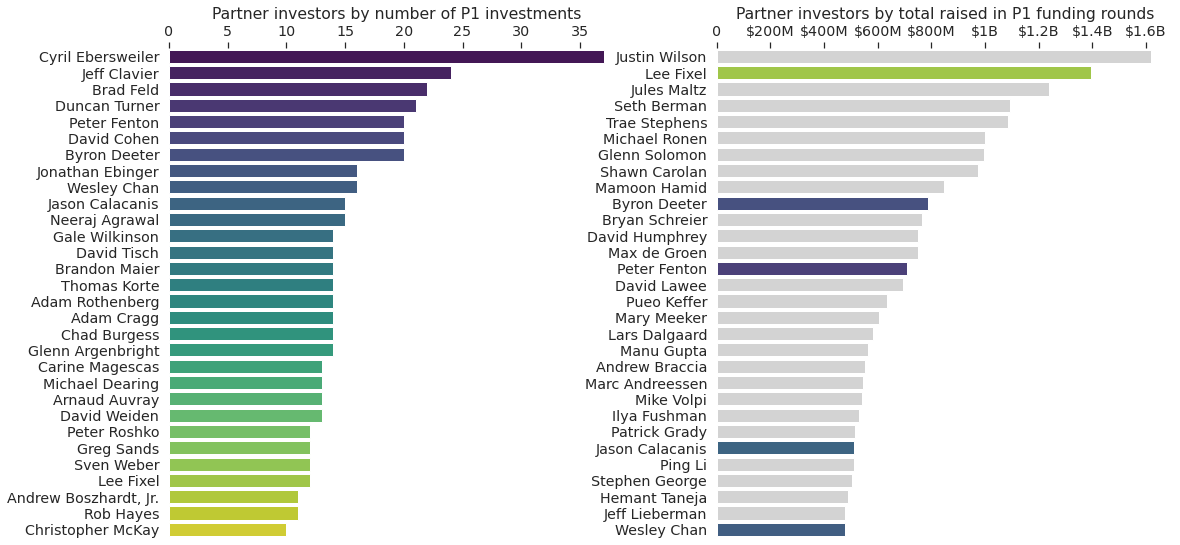

In [4]:
# Plot the investor subplots
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,9))

# By count
bar1 = sns.barplot(x='org_name', y='partner_name', palette='viridis', data=p1_p_invest_count, orient='h', ax=ax[0])
ax[0].xaxis.set_ticks_position('top')
ax[0].set_title('Partner investors by number of P1 investments')
ax[0].set_xlabel('')
ax[0].set_ylabel('')

# By cash
bar2 = sns.barplot(x='raised_amount_usd', y='partner_name', color='lightgrey',data=p1_p_invest_cash, orient='h', ax=ax[1])
ax[1].xaxis.set_ticks_position('top')
ax[1].xaxis.set_major_formatter(ticker.FuncFormatter(reformat_large_tick_values))
ax[1].set_title('Partner investors by total raised in P1 funding rounds')
ax[1].set_xlabel('')
ax[1].set_ylabel('')

# Make overlapping companies share facecolor
patch_h = []
for patch in bar1.patches:
    reading = patch.get_facecolor()
    patch_h.append(reading)
match_colors = dict(zip(p1_p_invest_count['partner_name'].to_list(), patch_h))
for idx, company in enumerate(p1_p_invest_cash['partner_name'].to_list()):
    if company in match_colors.keys():
        bar2.patches[idx].set_facecolor(match_colors[company])

# Display
sns.despine(left=True, bottom=True)
plt.show()

We can see a number of Midas List VCs on both left and right bar plots, with minimal overlap between the two. 

### How did the Pledge 1% community grow over time?

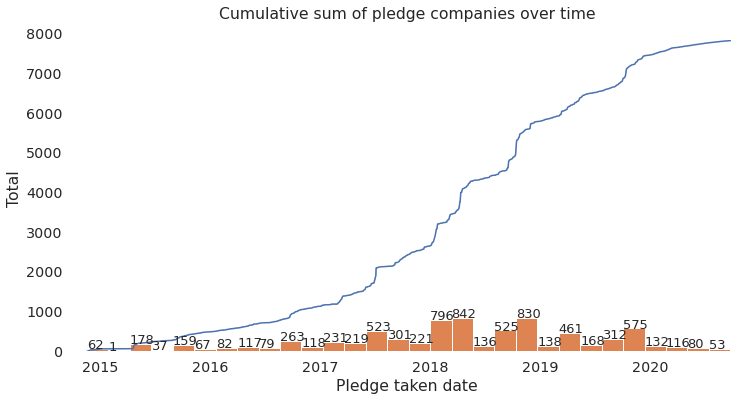

In [5]:
# Create cumultative total column
pledge1['p1_date'] = pd.to_datetime(pledge1['p1_date'])
pledge1['p1_tag'] = pledge1['p1_tag'].apply(lambda x: 1 if x == True else 0)
pledge1['cumsum'] = pledge1.sort_values('p1_date')['p1_tag'].cumsum()

_, ax = plt.subplots(figsize=(12, 6))

# Lineplot
sns.lineplot(x='p1_date',y='cumsum',data=pledge1)

# Histogram
counts,bins,_ = plt.hist(pledge1['p1_date'], bins=30)
for c,b in zip(counts, bins):     
    plt.gca().text(b + 0.15, c, str(int(c)), fontsize='small') # +0.15 to center text

# Labels
ax.set_xlim(pd.Timestamp('2014-10-01'),pd.Timestamp('2020-11-01'))
ax.set_title('Cumulative sum of pledge companies over time')
ax.set_xlabel('Pledge taken date')
ax.set_ylabel('Total')
rs b
# Display
sns.despine(left=True, bottom=True)
plt.show()

After Pledge 1% was founded, it grew to 12K members by December 2020. The large jumps in this growth can be attributed to our accelerator partners who built a membership pipeline to expand the movement. It is common for some of their early stage startups to not be found within Crunchbase, which is why the number for this project is around 7.4K.

## Comparing the Pledge 1% with the Crunchbase community

In [6]:
# Merge p1 and org dataframes on the uuid
df = pd.merge(org, pledge1, how='left',on='uuid')

# Review Pandas Profiling Report of dataframe & update columns
df = df[['name','founded_on','p1_date','p1_tag', 'primary_role', 'employee_count', 'country_code']]

# Convert Boolean to binary
df['p1_tag'] = df['p1_tag'].apply(lambda x: 1 if x == True else 0)

# Convert to datetime objects
df['p1_date'] = pd.to_datetime(df['p1_date'])

# Get OutOfBoundsDatetime error if do not coerce for CB native timestamp columns
df['founded_on'] = pd.to_datetime(df['founded_on'],errors='coerce').dt.strftime('%Y-%m-%d')

# Create new pledge1 dataframe that sorts by chronological order that the company took the pledge
p1 = df[df['p1_tag']==1].sort_values('p1_date')

# Is there a difference in investments between investors and companies? 
investor_df = df[df['primary_role'] == 'investor']
company_df = df[df['primary_role'] == 'company']
print(f"The number of investors in the dataset is: {len(investor_df)}")
print(f"The number of companies in the dataset is: {len(company_df)}")
invested_investors = investor_df[investor_df['p1_tag']==1]
invested_companies = company_df[company_df['p1_tag']==1]
print(f"The percentage of CB investors that have joined Pledge 1% is {round((len(invested_investors)/len(investor_df))*100,3)}%")
print(f"The percentage of CB companies that have joined Pledge 1% is {round((len(invested_companies)/len(company_df))*100,3)}%")

The number of investors in the dataset is: 52435
The number of companies in the dataset is: 1065201
The percentage of CB investors that have joined Pledge 1% is 0.32%
The percentage of CB companies that have joined Pledge 1% is 0.716%


Pledge 1% makes up less than 1% of the Crunchbase organizational data.

### Adding an `age` feature to the data for comparisons.

In [7]:
now = datetime(2020, 9, 8).date()
df['founded_on'] = pd.to_datetime(df['founded_on']).dt.date
age = []
for i in range (len(df['founded_on'])):
    if not pd.isna(df['founded_on'][i]):
        val = now - df['founded_on'][i]
        if val.days >= 0:
            age.append(round(((val.days)/365)))
        else:
            age.append(np.NaN)
    else:
        age.append(np.NaN)
df['age'] = pd.Series(age)

print(f"There are {len(df[df['age'].isna()])} entries with no founded_on date. Let's remove these from the dataset.")
df = df[df['age'].notna()].reset_index(drop=True)
cb = df.copy()
p1 = cb[cb['p1_tag']==1]
print()
print(f"Now, there are {len(df[df['age'].isna()])} with the value of NaN.\n")

# More established, older P1 companies
print('The more established, older Pledge 1% Companies:\n')
print(p1[p1['age'] > 100][['name', 'age']].sort_values('age', ascending=False).head(10).to_string(index=False))

There are 252682 entries with no founded_on date. Let's remove these from the dataset.

Now, there are 0 with the value of NaN.

The more established, older Pledge 1% Companies:

                         name    age
   The Royal Bank of Scotland  294.0
              Banco do Brasil  212.0
                          ACS  204.0
                      Westpac  204.0
       University of Virginia  202.0
           Colgate University  202.0
        University of Alabama  190.0
          Wesleyan University  190.0
 Schneider Electric Indonesia  185.0
             B. Braun Medical  182.0


Some of the older organizations that have taken the pledge are banks and universities.

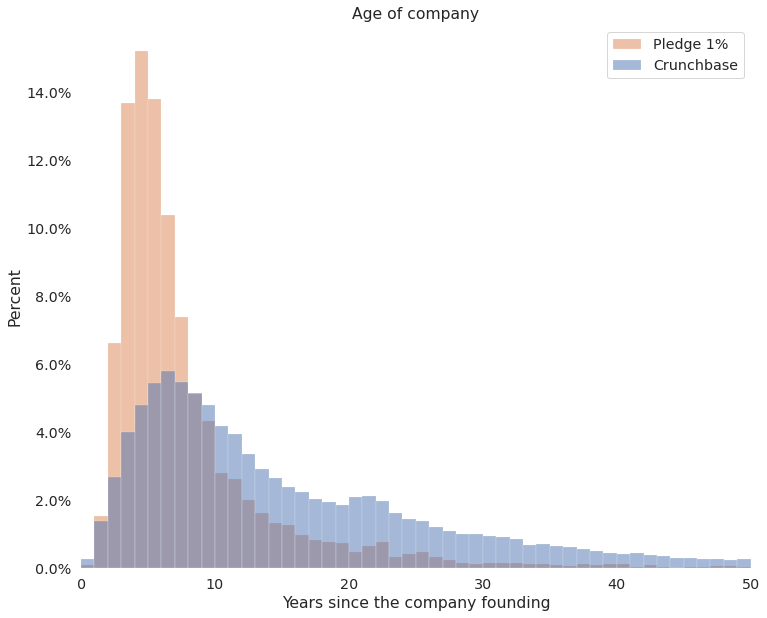

In [8]:
# Add weights for plotting
cb['weight'] = 0
cb['weight'][cb['p1_tag']==0] = 1/len(cb)
cb['weight'][cb['p1_tag']==1] = 1/len(p1)

# Plot the finvestor type subplots
_, ax = plt.subplots(figsize=(12, 10))

# Crunchbase
sns.histplot(x='age', data=cb, weights='weight', binwidth=1, hue='p1_tag', kde=False)
ax.set_xlim([0, 50])
ax.set_title('Age of company')
ax.set_ylabel('Percent')
ax.set_xlabel('Years since the company founding')

# Display
plt.legend(title='', loc='upper right', labels=['Pledge 1%', 'Crunchbase'])
sns.despine(left=True, bottom=True)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

Both company distributions are positively skewed. Pledge 1% companies tend to have a younger ages than the full datasets' companies, younger companies take up a higher percentage in Pledge 1%, and Crunchbase's standard deviation (\~23 years) is nearly twice the size of Pledge 1%'s (\~13 years).

### Reviewing `employee_size`. How large are the companies in Crunchbase versus Pledge 1%?

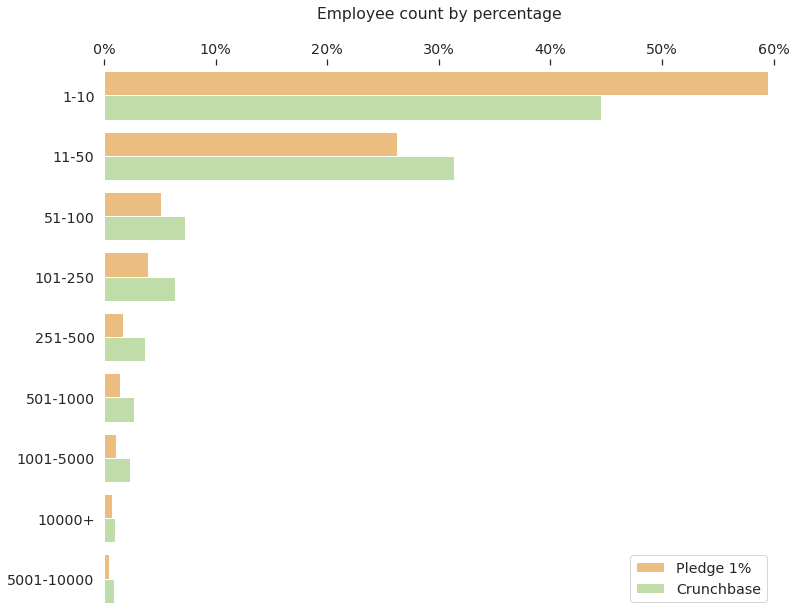

In [9]:
# Convert employee_count 'unknown' to np.nan to get accurate missing value count
df['employee_count'] = df['employee_count'].apply(lambda x: np.NaN if x == 'unknown' else x)
cb = df.copy()
p1 = cb[cb['p1_tag']==1]

# Create a new aggregated dataset grouped on investor_name by aggregating unique investor organizations
cb_employee_count = cb.groupby('employee_count', as_index=False)\
                      .agg({'name':'count'})\
                      .sort_values('name', ascending=False).reset_index(drop=True)
cb_employee_count['percent'] = round((cb_employee_count['name']/cb_employee_count['name'].sum())*100,2)

# Create a new aggregated dataset grouped on investor_name by aggregating unique investor organizations
p1_employee_count = p1.groupby('employee_count', as_index=False)\
                      .agg({'name':'count'})\
                      .sort_values('name', ascending=False).reset_index(drop=True)
p1_employee_count['percent'] = round((p1_employee_count['name']/p1_employee_count['name'].sum())*100,2)

# Combine the two 
cb_employee_count['type'] = 'Crunchbase'
p1_employee_count['type'] = 'Pledge 1%'
p1_employee_count = p1_employee_count.append(cb_employee_count)

# Plot the investor type subplots
_, ax = plt.subplots(figsize=(12, 10), sharey=True)
xticks = ticker.FormatStrFormatter('%.0f%%')

# Crunchbase
sns.barplot(x='percent', y='employee_count', data=p1_employee_count, palette='Spectral', orient='h', ci=None, hue='type')
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_major_formatter(xticks)
ax.set_xlim([0,60])
ax.set_title('Employee count by percentage\n')
ax.set_ylabel('')
ax.set_xlabel('')

# Display
plt.legend(title='', loc='lower right', labels=['Pledge 1%', 'Crunchbase'])
sns.despine(left=True, bottom=True)
plt.show()

Compared to the entire dataset, Pledge 1% companies are smaller than Crunchbase companies by percentage.

### Reviewing `country_code`. Where are companies located in Crunchbase versus Pledge 1%?

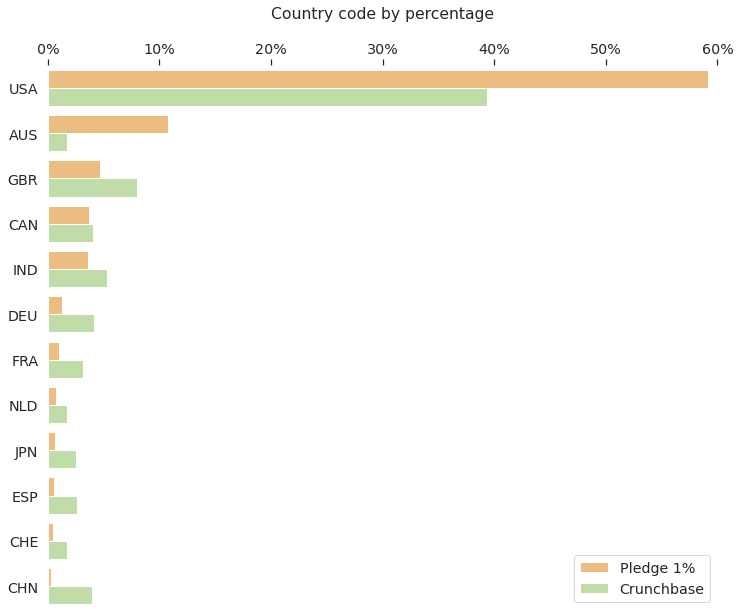

In [10]:
cb = df.copy()
p1 = cb[cb['p1_tag']==1]

# Create a new aggregated dataset grouped on investor_name by aggregating unique investor organizations
cb_country = cb.groupby('country_code', as_index=False)\
               .agg({'name':'count'})\
               .sort_values('name', ascending=False).reset_index(drop=True)
cb_country['percent'] = round((cb_country['name']/cb_country['name'].sum())*100,2)

# Create a new aggregated dataset grouped on investor_name by aggregating unique investor organizations
p1_country = p1.groupby('country_code', as_index=False)\
               .agg({'name':'count'})\
               .sort_values('name', ascending=False).reset_index(drop=True)
p1_country['percent'] = round((p1_country['name']/p1_country['name'].sum())*100,2)

# Combine the two 
num_to_compare = 12
cb_country['type'] = 'Crunchbase'
p1_country['type'] = 'Pledge 1%'
cb_country = cb_country.iloc[:num_to_compare,:]
top_countries = cb_country['country_code'].to_list()
p1_country = p1_country[p1_country['country_code'].isin(top_countries)]
p1_country = p1_country.append(cb_country)

# Plot the finvestor type subplots
_, ax = plt.subplots(figsize=(12, 10))
xticks = ticker.FormatStrFormatter('%.0f%%')

# Crunchbase
sns.barplot(x='percent', y='country_code', data=p1_country, palette='Spectral', orient='h', ci=None, hue='type')
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_major_formatter(xticks)
ax.set_xlim([0,60])
ax.set_title('Country code by percentage\n')
ax.set_ylabel('')
ax.set_xlabel('')

# Display
plt.legend(title='', loc='lower right', labels=['Pledge 1%', 'Crunchbase'])
sns.despine(left=True, bottom=True)
plt.show()

Pledge 1% has a higher representation of companies in the United States and Australia than Crunchbase and seemingly lower representation in their other top countries.

### What types of investors are in Crunchbase versus Pledge 1%?

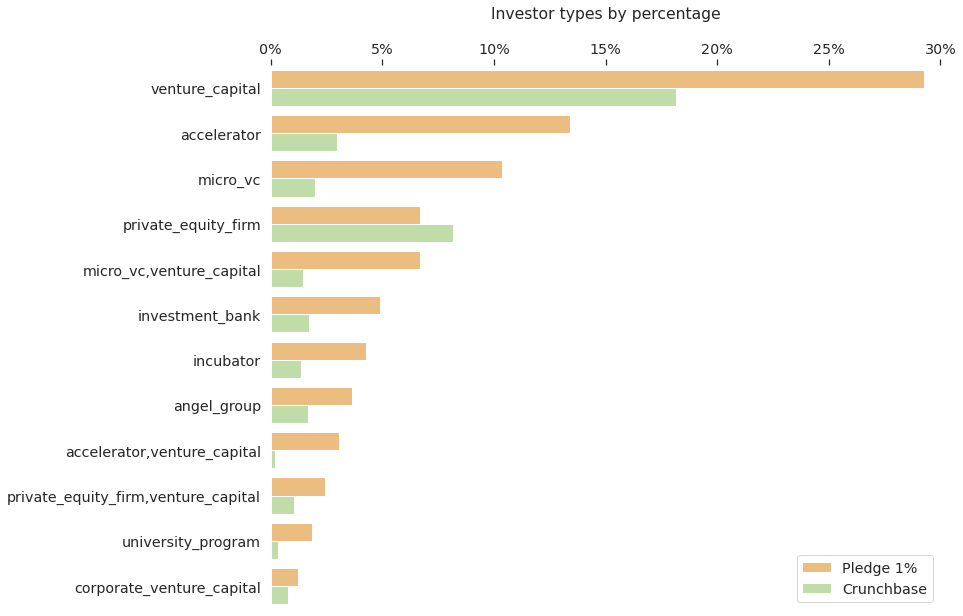

In [11]:
# Load in the investor dataframe
inr = load_the_csvs(loc=INPUT, data=['investors'],verbose=False)

# Merge investor and p1 datasets on org uuid
cb = pd.merge(inr, pledge1, how='left',on='uuid')
cb['p1_tag'] = cb['p1_tag'].apply(lambda x: 1 if x == True else 0)

# Update columns
cb = cb[['name','investor_types','type','p1_tag']]
p1 = cb[cb['p1_tag']==1]

# Create a new aggregated dataset grouped on investor_name by aggregating unique investor organizations
cb_investor_type = cb.groupby('investor_types', as_index=False)\
                      .agg({'name':'count'})\
                      .sort_values('name', ascending=False).reset_index(drop=True)
cb_investor_type['percent'] = round((cb_investor_type['name']/cb_investor_type['name'].sum())*100,2)

# Create a new aggregated dataset grouped on investor_name by aggregating unique investor organizations
p1_investor_type = p1.groupby('investor_types', as_index=False)\
                      .agg({'name':'count'})\
                      .sort_values('name', ascending=False).reset_index(drop=True)
p1_investor_type['percent'] = round((p1_investor_type['name']/p1_investor_type['name'].sum())*100,2)


# Combine the two 
num_to_compare = 12
cb_investor_type['type'] = 'Crunchbase'
p1_investor_type['type'] = 'Pledge 1%'
p1_investor_type = p1_investor_type.iloc[:num_to_compare,:]
top_investors = p1_investor_type['investor_types'].to_list()
cb_investor_type = cb_investor_type[cb_investor_type['investor_types'].isin(top_investors)]
p1_investor_type = p1_investor_type.append(cb_investor_type)

# Plot the finvestor type subplots
_, ax = plt.subplots(figsize=(12, 10))
xticks = ticker.FormatStrFormatter('%.0f%%')

# Crunchbase
sns.barplot(x='percent', y='investor_types', data=p1_investor_type, palette='Spectral', orient='h', ci=None, hue='type')
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_major_formatter(xticks)
ax.set_xlim([0,30])
ax.set_title('Investor types by percentage\n')
ax.set_ylabel('')
ax.set_xlabel('')

# Display
plt.legend(title='', loc='lower right', labels=['Pledge 1%', 'Crunchbase'])
sns.despine(left=True, bottom=True)
plt.show()

Pledge 1% has a higher representation of companies funded by early stage venture capital than Crunchbase.

### What types of funding rounds are in Crunchbase versus Pledge 1%?

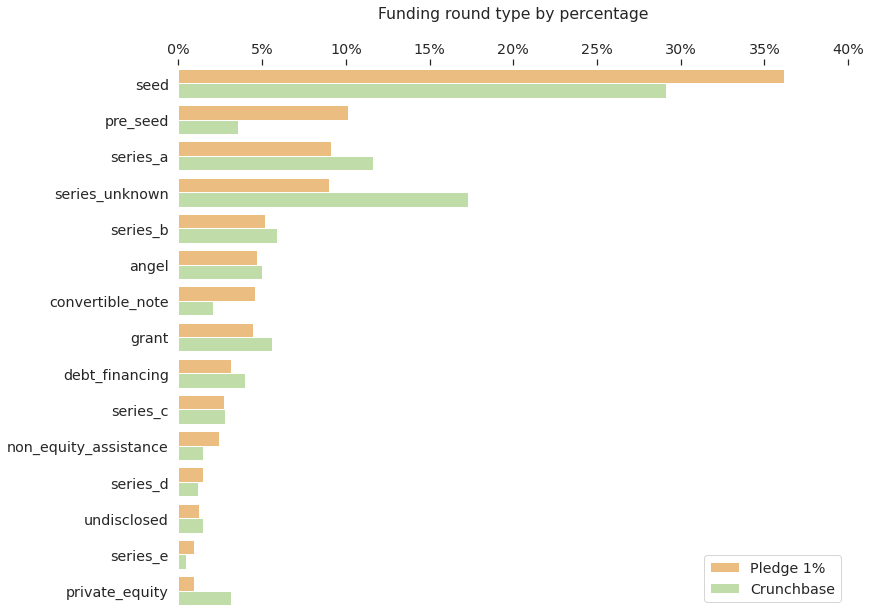

In [12]:
# Merge funding round and p1 datasets on org uuid
pledge1['org_uuid'] = pledge1['uuid']
cb = pd.merge(fun, pledge1, how='left',on='org_uuid')
cb['p1_tag'] = cb['p1_tag'].apply(lambda x: 1 if x == True else 0)

# Update columns
cb = cb[['org_name', 'investment_type', 'investor_count', 'p1_tag']]
cb['investor_count'] = cb['investor_count'].fillna(0)
p1 = cb[cb['p1_tag']==1]

# Create a new aggregated dataset grouped on investor_name by aggregating unique organizations
cb_fund_round_type = cb.groupby('investment_type', as_index=False)\
                       .agg({'org_name':'count'})\
                       .sort_values('org_name', ascending=False).reset_index(drop=True)
cb_fund_round_type['percent'] = round((cb_fund_round_type['org_name']/cb_fund_round_type['org_name'].sum())*100,2)

# Create a new aggregated dataset grouped on investor_name by aggregating unique organizations
p1_fund_round_type = p1.groupby('investment_type', as_index=False)\
                       .agg({'org_name':'count'})\
                       .sort_values('org_name', ascending=False).reset_index(drop=True)
p1_fund_round_type['percent'] = round((p1_fund_round_type['org_name']/p1_fund_round_type['org_name'].sum())*100,2)


# Combine the two 
num_to_compare = 15
cb_fund_round_type['type'] = 'Crunchbase'
p1_fund_round_type['type'] = 'Pledge 1%'
p1_fund_round_type = p1_fund_round_type.iloc[:num_to_compare,:]
top = p1_fund_round_type['investment_type'].to_list()
cb_fund_round_type = cb_fund_round_type[cb_fund_round_type['investment_type'].isin(top)]
p1_fund_round_type = p1_fund_round_type.append(cb_fund_round_type)

# Plot the finvestor type subplots
_, ax = plt.subplots(figsize=(12, 10))
xticks = ticker.FormatStrFormatter('%.0f%%')

# Crunchbase
sns.barplot(x='percent', y='investment_type', data=p1_fund_round_type, palette='Spectral', orient='h', ci=None, hue='type')
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_major_formatter(xticks)
ax.set_xlim([0,40])
ax.set_title('Funding round type by percentage\n')
ax.set_ylabel('')
ax.set_xlabel('')

# Display
plt.legend(title='', loc='lower right', labels=['Pledge 1%', 'Crunchbase'])
sns.despine(left=True, bottom=True)
plt.show()

Pledge 1% funding rounds have a higher representation of seed and pre-seed investments, which also tracks well with the knowledge that Pledge 1% companies are typically early stage companies.